In [141]:
from astropy.io import fits
import numpy as np
import glob
import matplotlib.pyplot as plt
import ccdproc
from astropy import units as u
import re
from astropy.stats import sigma_clip
from scipy.ndimage import shift, center_of_mass, gaussian_filter1d
from photutils.centroids import centroid_com
import os
import astroscrappy
from scipy.stats import linregress
import pandas as pd
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from astropy.nddata import Cutout2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle, Wedge
from astropy.stats import sigma_clipped_stats

my_path = "/Users/yzb4en/Downloads/TOI-2046b"

## Reduce the Data

In [2]:
bias_files = sorted(glob.glob(f"{my_path}/Bias_BIN2_20251031_*.fits"))

bias_stack = []
for f in bias_files:
    with fits.open(f) as hdul:
        bias_stack.append(hdul[0].data.astype(float))

master_bias = np.median(np.stack(bias_stack, axis=0), axis=0)
fits.writeto(f"{my_path}/master_bias.fits", master_bias, overwrite=True)

In [3]:
dark_files = sorted(glob.glob(f"{my_path}/Dark_BIN2_20251031_*.fits"))

dark_corr = []
for f in dark_files:
    with fits.open(f) as hdul:
        dark_corr.append(hdul[0].data.astype(float) - master_bias)

master_dark = np.median(np.stack(dark_corr, axis=0), axis=0)
fits.writeto(f"{my_path}/master_dark.fits", master_dark, overwrite=True)

In [4]:
flat_files = sorted(glob.glob(f"{my_path}/domeflat_g_*-2.fits"))

flat_corr = []
for f in flat_files:
    with fits.open(f) as hdul:
        img = hdul[0].data.astype(float)
        img = img - master_bias - master_dark
        flat_corr.append(img)

master_flat = np.median(np.stack(flat_corr, axis=0), axis=0)
fits.writeto(f"{my_path}/master_flat.fits", master_flat, overwrite=True)

In [5]:
sci_files = sorted(f for f in glob.glob(f"{my_path}/TOI-2046b_g_20251031_*.fits") if os.path.splitext(os.path.basename(f))[0].rsplit("_", 1)[-1].isdigit())

master_bias = fits.getdata(f"{my_path}/master_bias.fits").astype(float)
master_dark = fits.getdata(f"{my_path}/master_dark.fits").astype(float)
master_flat = fits.getdata(f"{my_path}/master_flat.fits").astype(float)

# Build 1D flat response
flat_response = np.median(master_flat, axis=0)
flat_response /= np.median(flat_response)
flat_response[flat_response == 0] = 1.0

for sci_file in sci_files:
    with fits.open(sci_file) as hdul:
        sci = hdul[0].data.astype(float)
        hdr = hdul[0].header

    # Exposure time
    exptime = float(hdr['EXPTIME'])  # seconds

    # Scale dark to science exposure time
    dark_scaled = master_dark * (exptime / 300.0)

    # Subtract bias and dark
    sci_corr = sci - master_bias - dark_scaled

    # Divide by 1D flat response
    sci_corr /= flat_response[np.newaxis, :]

    # Save reduced file
    outname = sci_file.replace(".fits", "_reduced.fits")
    fits.writeto(outname, sci_corr, hdr, overwrite=True)

In [6]:
# check if we need overscan subtraction (this shows we don't)

def check_overscan(fpath):
    """
    Inspect FITS header and data for overscan regions.
    Returns a dict with header info and simple statistics.
    """
    with fits.open(fpath) as hdul:
        hdr = hdul[0].header
        data = hdul[0].data.astype(float)

    info = {"file": fpath}

    # Look for standard overscan keywords
    info["BIASSEC"] = hdr.get("BIASSEC", None)
    info["TRIMSEC"] = hdr.get("TRIMSEC", None)

    # If overscan keywords exist, parse them
    if info["BIASSEC"]:
        # Example: '[2050:2100,1:2048]'
        sec = info["BIASSEC"].strip("[]").split(",")
        x1, x2 = map(int, sec[0].split(":"))
        y1, y2 = map(int, sec[1].split(":"))
        overscan_region = data[y1-1:y2, x1-1:x2]
        info["overscan_mean"] = np.mean(overscan_region)
        info["overscan_std"] = np.std(overscan_region)
    else:
        info["overscan_mean"] = None
        info["overscan_std"] = None

    # Compare median of science region vs overscan (if available)
    if info["overscan_mean"] is not None:
        trimmed_region = None
        if info["TRIMSEC"]:
            sec = info["TRIMSEC"].strip("[]").split(",")
            x1, x2 = map(int, sec[0].split(":"))
            y1, y2 = map(int, sec[1].split(":"))
            trimmed_region = data[y1-1:y2, x1-1:x2]
        else:
            trimmed_region = data

        info["science_median"] = np.median(trimmed_region)
    else:
        info["science_median"] = np.median(data)

    return info

# Run checks on all science frames
for sci_file in sci_files:
    info = check_overscan(sci_file)
    print(f"\nFile: {info['file']}")
    print(f"  BIASSEC: {info['BIASSEC']}")
    print(f"  TRIMSEC: {info['TRIMSEC']}")
    print(f"  Overscan mean: {info['overscan_mean']}")
    print(f"  Overscan std: {info['overscan_std']}")
    print(f"  Science median: {info['science_median']}")


File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1303.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  Overscan std: None
  Science median: 1304.0

File: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207.fits
  BIASSEC: None
  TRIMSEC: None
  Overscan mean: None
  

## Align Images and Sigma Clipping

In [7]:
def estimate_gain(bias_frames, sigma=3):
    """
    Estimate CCD gain from bias frames using the variance method.
    
    Parameters
    ----------
    bias_frames : list of str
        List of file paths to bias frames.
    sigma : float, optional
        Sigma threshold for sigma clipping (default=3).
    
    Returns
    -------
    gain : float
        Estimated gain in e-/ADU.
    """
    # Load all bias frames into a 3D array
    bias_data = np.array([fits.getdata(f).astype(float) for f in bias_frames])
    
    # Mean and variance per pixel across frames
    mean_image = np.mean(bias_data, axis=0)
    var_image = np.var(bias_data, axis=0, ddof=1)
    
    # Flatten and sigma-clip to remove outliers
    mean_flat = mean_image.flatten()
    var_flat = var_image.flatten()
    mean_clipped = sigma_clip(mean_flat, sigma=sigma)
    var_clipped = sigma_clip(var_flat, sigma=sigma)
    
    valid_mask = ~mean_clipped.mask & ~var_clipped.mask
    mean_valid = mean_flat[valid_mask]
    var_valid = var_flat[valid_mask]
    
    # Linear regression: variance = (mean - offset)/gain
    slope, intercept, _, _, _ = linregress(mean_valid, var_valid)
    print(f"Slope: {slope:.6e}, Intercept: {intercept:.6e}")
    
    # Gain
    gain = 1.0 / slope if slope > 0 else np.nan
    
    print(f"Estimated gain: {gain:.3f} e-/ADU")
    
    return gain

if len(bias_files) >= 5:
    gain = estimate_gain(bias_files[:10], sigma=3)
else:
    print("Warning: Not enough bias frames for gain/read noise estimation")
    gain = np.nan

Slope: 7.939528e-01, Intercept: -6.367305e+02
Estimated gain: 1.260 e-/ADU


In [8]:
def calculate_photon_noise(science_files, master_bias, master_dark, gain):
    """
    Calculate mean photon noise from science frames using master bias/dark and known gain.

    Parameters
    ----------
    science_files : list of str
        List of FITS science frame file paths.
    master_bias : 2D array
        Master bias frame in ADU.
    master_dark : 2D array
        Master dark frame in ADU (scaled to exposure time).
    gain : float
        CCD gain in e-/ADU.

    Returns
    -------
    mean_photon_noise : float
        Mean photon noise across all frames (in electrons).
    std_photon_noise : float
        Standard deviation of per-frame mean photon noise (in electrons).
    """
    per_file_means = []

    for f in science_files:
        with fits.open(f) as hdul:
            image_adu = hdul[0].data.astype(float)

        # Calibrate: subtract bias and dark
        calibrated_adu = image_adu - master_bias - master_dark

        # Convert to electrons
        N_e = gain * np.clip(calibrated_adu, a_min=0, a_max=None)

        # Photon noise per pixel
        photon_noise_e = np.sqrt(N_e)

        # Mean photon noise for this frame
        per_file_means.append(np.mean(photon_noise_e))

    per_file_means = np.array(per_file_means)

    # Mean and standard deviation across frames
    mean_photon_noise = float(np.mean(per_file_means))
    std_photon_noise = float(np.std(per_file_means, ddof=1))

    print(f"Mean photon noise: {mean_photon_noise:.3f} e-")
    print(f"Std dev of photon noise across frames: {std_photon_noise:.3f} e-")

    return mean_photon_noise, std_photon_noise

gain = 1.260
mean_photon_noise, std_photon_noise = calculate_photon_noise(sci_files, master_bias, master_dark, gain)

Mean photon noise: 11.313 e-
Std dev of photon noise across frames: 3.319 e-


In [9]:
def calculate_read_noise(bias_files, gain):
    """
    Calculate read noise from bias frames and known gain.

    Parameters
    ----------
    bias_files : list of str
        List of FITS bias frame file paths.
    gain : float
        CCD gain in e-/ADU.

    Returns
    -------
    mean_read_noise : float
        Mean read noise across all pixels (in electrons).
    std_read_noise : float
        Standard deviation of read noise across pixels (in electrons).
    """
    # Load all bias frames
    bias_stack = []
    for f in bias_files:
        with fits.open(f) as hdul:
            bias_stack.append(hdul[0].data.astype(float))
    bias_stack = np.stack(bias_stack, axis=0)

    # Compute variance across frames (per pixel) in ADU^2
    var_image = np.var(bias_stack, axis=0, ddof=1)

    # Convert variance to electrons^2
    var_image_e2 = (gain**2) * var_image

    # Per-pixel read noise (RMS in electrons)
    read_noise_map = np.sqrt(var_image_e2)

    # Mean and standard deviation across pixels
    mean_read_noise = float(np.mean(read_noise_map))
    std_read_noise = float(np.std(read_noise_map, ddof=1))

    print(f"Mean read noise: {mean_read_noise:.3f} e-")
    print(f"Std dev of read noise across pixels: {std_read_noise:.3f} e-")

    return mean_read_noise, std_read_noise

gain = 1.260  # e-/ADU
if len(bias_files) >= 5:
    read_noise = calculate_read_noise(bias_files, gain)
else:
    print("Not enough bias frames for reliable read noise estimation")

Mean read noise: 19.544 e-
Std dev of read noise across pixels: 3.650 e-


In [149]:
sci_files_red = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_reduced.fits"))

# Reference centroid (first frame)
with fits.open(sci_files_red[0]) as hdul:
    ref_img = hdul[0].data.astype(float)
ref_cy, ref_cx = centroid_com(ref_img)

# Instrument parameters
gain = 1.260      # e-/ADU
readnoise = 19.544  # e- (RMS)
satlevel = 60000  # set to your saturation ADU (e.g., 50000) if known

# L.A.Cosmic parameters (conservative defaults)
# - sigclip: detection threshold (increase to be more conservative)
# - sigfrac: fractional threshold for neighbors
# - objlim: star/CR discrimination; higher reduces false flags on stars
lac_kwargs = dict(
    sigclip=7.0,      # start at >7sig; increase if stars get hit
    sigfrac=0.3,      # neighbor fraction
    objlim=10.0,       # try 5–10; higher = safer for stellar cores
    gain=gain,
    readnoise=readnoise,
    satlevel=satlevel,
    niter=3,          # iterations; reduce if too aggressive
    sepmed=True,      # robust background estimation
    cleantype='medmask'  # median replacement within mask
)

for f in sci_files_red:
    with fits.open(f) as hdul:
        img = hdul[0].data.astype(float)
        hdr = hdul[0].header

    # align to reference by centroid
    cy, cx = centroid_com(img)
    dy, dx = (ref_cy - cy, ref_cx - cx)
    aligned = shift(img, shift=(dy, dx), mode="nearest")

    # run L.A.Cosmic
    crmask, cleaned = astroscrappy.detect_cosmics(aligned, **lac_kwargs)

    # save cleaned output (per file)
    outname = f.replace("_reduced.fits", "_rc.fits")
    fits.writeto(outname, cleaned, hdr, overwrite=True)

    # report outlier stats
    n_cr = int(np.sum(crmask))
    frac = n_cr / crmask.size
    print(f"{f}: cosmic rays flagged={n_cr} ({frac:.6f}) → {outname}")

/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_reduced.fits: cosmic rays flagged=2337 (0.001001) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_reduced.fits: cosmic rays flagged=4242 (0.001817) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_reduced.fits: cosmic rays flagged=4277 (0.001832) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_reduced.fits: cosmic rays flagged=4386 (0.001879) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_reduced.fits: cosmic rays flagged=4206 (0.001801) → /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_rc.fits
/Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_reduced.fits: cosm

## Image Profiles

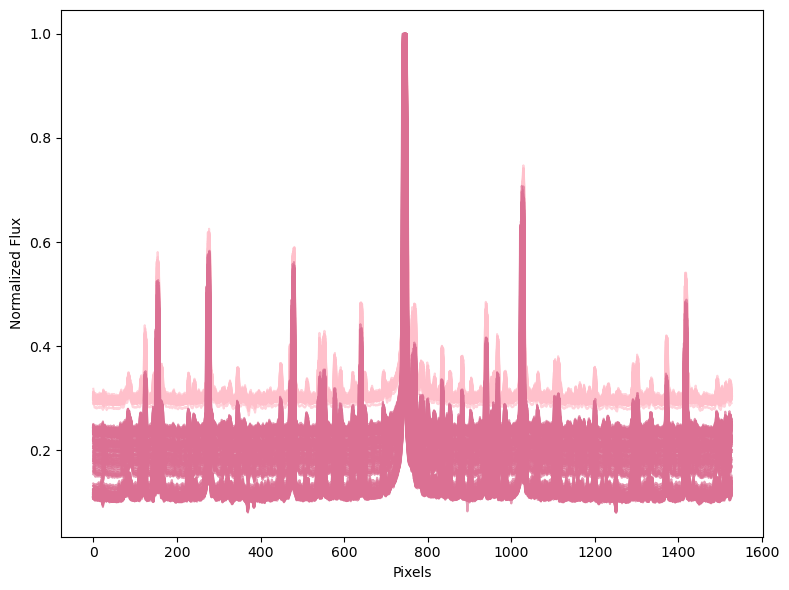

In [146]:
sci_files_rc = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_rc.fits"))

plt.figure(figsize=(8,6))

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        hdr = hdul[0].header
        exptime = hdr.get("EXPTIME", None)  # exposure time keyword

        # Collapse along y-axis to get 1D profile
        profile = np.mean(data, axis=0)

        # --- Normalize flux ---
        if exptime:
            profile = profile / exptime   # counts per second
        profile = profile / profile.max() # scale so peak = 1

        # Choose color and label
        if exptime == 45:
            color, label = "pink", "45s"
        elif exptime == 30:
            color, label = "palevioletred", "30s"
        else:
            color, label = "gray", f"{exptime}s" if exptime else "unknown"

        plt.plot(profile, color=color, alpha=0.7)

plt.xlabel("Pixels")
plt.ylabel("Normalized Flux")
plt.tight_layout()
plt.savefig("5110_final_image_profile.pdf")
plt.show()

=== Stability Analysis ===
Number of frames: 277
Mean PSF sigma: 3.2651993367708054
Stddev PSF sigma: 0.3690994903183763
Centroid drift (x): 1.3313291796213584
Centroid drift (y): 0.8650804153025451
Flux stability (mean/std): 118.7151246805931 31.136732650276983
Normalized flux (0–1): 0.4038996233825637


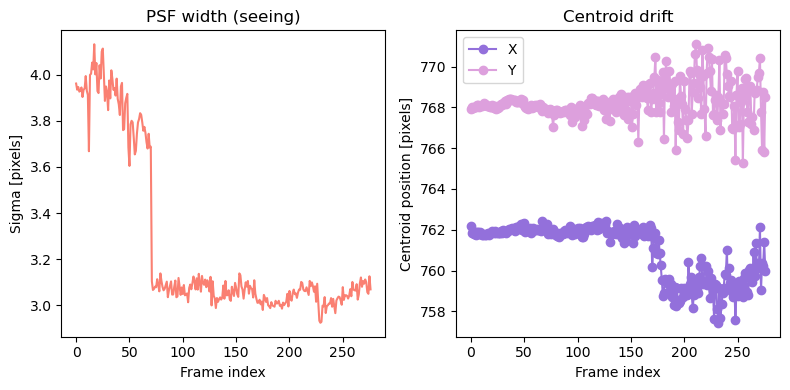

In [147]:
# --- Gaussian model for PSF fitting ---
def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

results = []

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        hdr = hdul[0].header
        exptime = hdr.get("EXPTIME", None)

        # Collapse along y-axis to get 1D profile
        profile = np.mean(data, axis=0)
        x = np.arange(len(profile))

        # Fit Gaussian to profile
        try:
            p0 = [np.max(profile), np.argmax(profile), 5.0, np.min(profile)]
            popt, _ = curve_fit(gaussian, x, profile, p0=p0)
            amp, mu, sigma, offset = popt
        except RuntimeError:
            sigma = np.nan
            mu = np.nan
            offset = np.nan

        # Centroid from center of mass
        cy, cx = center_of_mass(data)

        results.append({
            "file": fname,
            "exptime": exptime,
            "centroid_x": cx,
            "centroid_y": cy,
            "psf_sigma": sigma,
            "flux_mean": np.mean(profile),
            "flux_std": np.std(profile)
        })

# --- Convert results to DataFrame ---
df = pd.DataFrame(results)

# --- Normalize flux to 0–1 range ---
flux = df['flux_mean'].values
flux_min, flux_max = np.nanmin(flux), np.nanmax(flux)
df['flux_norm01'] = (flux - flux_min) / (flux_max - flux_min)

# --- Statistical summaries ---
print("=== Stability Analysis ===")
print("Number of frames:", len(df))
print("Mean PSF sigma:", df['psf_sigma'].mean())
print("Stddev PSF sigma:", df['psf_sigma'].std())
print("Centroid drift (x):", df['centroid_x'].std())
print("Centroid drift (y):", df['centroid_y'].std())
print("Flux stability (mean/std):", df['flux_mean'].mean(), df['flux_std'].mean())
print("Normalized flux (0–1):", df['flux_norm01'].mean())

# --- Plots ---
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(df['psf_sigma'], '-', c='salmon')
plt.title("PSF width (seeing)")
plt.xlabel("Frame index")
plt.ylabel("Sigma [pixels]")

plt.subplot(1,2,2)
plt.plot(df['centroid_x'], 'o-', label="X", c='mediumpurple')
plt.plot(df['centroid_y'], 'o-', label="Y", c='plum')
plt.title("Centroid drift")
plt.xlabel("Frame index")
plt.ylabel("Centroid position [pixels]")
plt.legend()

#plt.subplot(1,3,3)
#plt.plot(df['flux_norm01'], 'o-', c='salmon')
#plt.title("Flux stability")
#plt.xlabel("Frame index")
#plt.ylabel("Normalized Flux")

plt.tight_layout()
plt.savefig('5110_final_seeing.pdf')
plt.show()

## Reference Stars

In [13]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (765 - 745) / 2   
    half_height_y = (765 - 745) / 2 

    # Center position (pixels)
    position = (755 + half_width_x, 755 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_toi.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_toi.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041712_toi.fits

/var/folders/g6/f4z5211s6zq9mr79tgz7pk1m0000gp/T/ipykernel_37911/3780382990.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


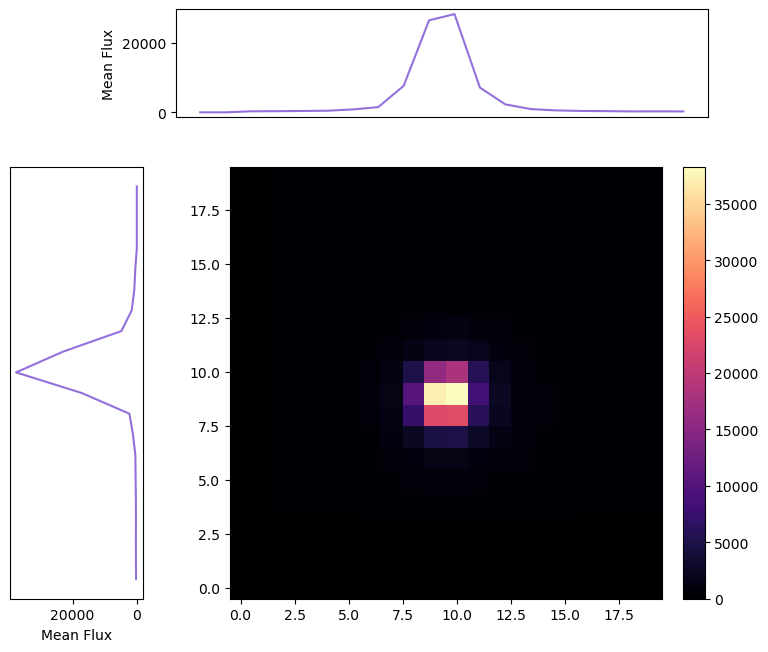

In [67]:
sci_files_toi = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_toi.fits"))

fname = sci_files_toi[0]
with fits.open(fname) as hdul:
    data = hdul[0].data.astype(float)
    hdr = hdul[0].header
    exptime = hdr.get("EXPTIME", None)

# --- Find centroid ---
y_centroid, x_centroid = center_of_mass(data)

# --- Shift the image so centroid is at the center ---
ny, nx = data.shape
shift_y = ny/2 - y_centroid
shift_x = nx/2 - x_centroid
data_centered = shift(data, shift=(shift_y, shift_x), order=3)

# --- Crop around the new center ---
half_size = 50
y_mid, x_mid = ny//2, nx//2
cutout = data_centered[y_mid-half_size:y_mid+half_size,
                       x_mid-half_size:x_mid+half_size]

# Define a narrower averaging window around the centroid
window = 1  # number of pixels to average over

# Central indices of the cutout
x_center = cutout.shape[1] // 2
y_center = cutout.shape[0] // 2

# Average only within ±window pixels around the center
profile_x = np.mean(cutout[y_center-window:y_center+window, :], axis=0)
profile_y = np.mean(cutout[:, x_center-window:x_center+window], axis=1)

# --- Plot ---
fig = plt.figure(figsize=(9,9))
# Three rows: spacer, x-profile, image+y-profile
gs = GridSpec(3, 2, width_ratios=[1,4], height_ratios=[0.5,1,4], hspace=0.25, wspace=0.1)

# X-profile in middle row, right column
ax_top = fig.add_subplot(gs[1,1])
ax_top.plot(profile_x, color='mediumpurple')
ax_top.set_ylabel("Mean Flux")
ax_top.set_xticks([])

# Y-profile in bottom row, left column
ax_left = fig.add_subplot(gs[-1,0])
ax_left.plot(profile_y, np.arange(len(profile_y)), color='mediumpurple')
ax_left.set_xlabel("Mean Flux")
ax_left.set_yticks([])

# Flip by 180°: invert both axes
ax_left.invert_yaxis()
ax_left.invert_xaxis()

# Image in bottom row, right column
ax_img = fig.add_subplot(gs[2,1])
im = ax_img.imshow(cutout, cmap="magma", origin="lower")
plt.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('5110_final_image_example.pdf')
plt.show()

In [14]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (775 - 755) / 2   
    half_height_y = (835 - 815) / 2 

    # Center position (pixels)
    position = (765 + half_width_x, 825 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref1.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref1.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

In [15]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (1375 - 1355) / 2   
    half_height_y = (1000 - 980) / 2 

    # Center position (pixels)
    position = (1365 + half_width_x, 990 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref2.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref2.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

In [16]:
def crop(hdu, wcs):
    # Define half-widths of the cutout
    half_width_x = (940 - 920) / 2   
    half_height_y = (265 - 245) / 2 

    # Center position (pixels)
    position = (930 + half_width_x, 255 + half_height_y)

    # Cutout size (ny, nx)
    size = (int(2*half_height_y), int(2*half_width_x))

    cutout = Cutout2D(hdu.data, position, size, wcs=wcs)
    return cutout.data

for fname in sci_files_rc:
    with fits.open(fname) as hdul:
        hdu = hdul[0]
        wcs = None
        try:
            wcs = WCS(hdu.header)
        except Exception:
            pass

        cropped_data = crop(hdu, wcs)

        # Create new HDU with cropped data
        hdu_cropped = fits.PrimaryHDU(cropped_data, header=hdu.header)

        # Build output filename
        outname = fname.replace("_rc.fits", "_ref3.fits")

        # Write to disk
        hdu_cropped.writeto(outname, overwrite=True)
        print(f"Saved cropped file: {outname}")

Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040701_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040804_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_040905_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041006_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041107_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041207_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041308_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041409_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041510_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_041611_ref3.fits
Saved cropped file: /Users/yzb4en/Downloads/TOI-2046b/TOI-2046b_g_20251031_04171

Star 1: bend-center radius ≈ 3.00 px (growth=3.00, SNR=3.50)
Star 2: bend-center radius ≈ 3.00 px (growth=3.00, SNR=3.00)
Star 3: bend-center radius ≈ 3.00 px (growth=3.00, SNR=3.00)
TOI-2046b: bend-center radius ≈ 3.00 px (growth=3.00, SNR=3.00)

Best overall aperture radius ≈ 3.00 px


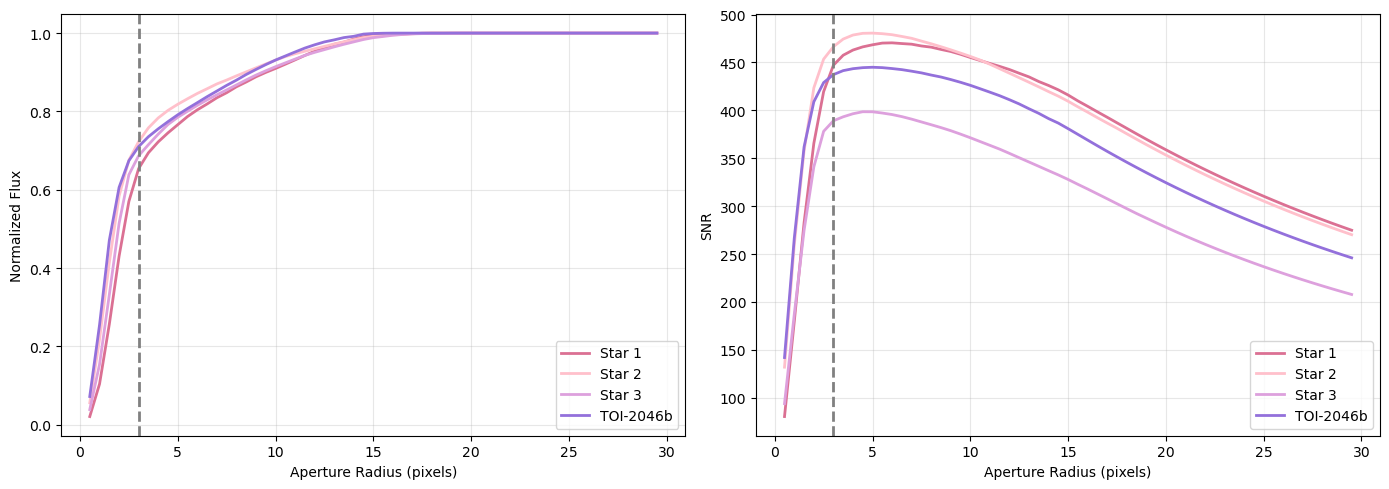

In [98]:
sci_files_ref1 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref1.fits"))
sci_files_ref2 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref2.fits"))
sci_files_ref3 = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_ref3.fits"))
sci_files_toi  = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_toi.fits"))

groups = {
    "Star 1": sci_files_ref1,
    "Star 2": sci_files_ref2,
    "Star 3": sci_files_ref3,
    "TOI-2046b": sci_files_toi,
}

GAIN = 1.260          # e-/ADU
READ_NOISE = 19.544   # e- per pixel

# Aperture radii
radii = np.arange(0.5, 30.0, 0.5)

# Sky annulus
SKY_R_IN = 35.0
SKY_R_OUT = 45.0

# Colors for plotting
colors = ["palevioletred", "pink", "plum", "mediumpurple"]

# Compute growth curve
def growth_curve(file_list):
    fluxes = []
    for fname in file_list:
        with fits.open(fname) as hdul:
            data = hdul[0].data.astype(float)
            hdr = hdul[0].header

        gain = hdr.get("GAIN", GAIN)
        x, y = centroid_com(data)

        frame_flux = []
        for r in radii:
            ap = CircularAperture((x, y), r=r)
            phot = aperture_photometry(data, ap)
            frame_flux.append(phot["aperture_sum"][0] * gain)

        fluxes.append(frame_flux)

    fluxes = np.array(fluxes)
    med_flux = np.median(fluxes, axis=0)
    return med_flux / med_flux[-1]

# Compute SNR curve
def snr_vs_radius(file_list):
    snrs = np.zeros((len(radii), len(file_list)))

    for j, fname in enumerate(file_list):
        with fits.open(fname) as hdul:
            data = hdul[0].data.astype(float)
            hdr = hdul[0].header

        gain = hdr.get("GAIN", GAIN)
        x, y = centroid_com(data)

        for i, r in enumerate(radii):
            ap = CircularAperture((x, y), r=r)
            ann = CircularAnnulus((x, y), r_in=SKY_R_IN, r_out=SKY_R_OUT)

            ap_phot = aperture_photometry(data, ap)
            ann_phot = aperture_photometry(data, ann)

            ap_area = ap.area
            ann_area = ann.area

            sky_per_pix = ann_phot["aperture_sum"][0] / ann_area
            sky_total = sky_per_pix * ap_area

            flux_adu = ap_phot["aperture_sum"][0] - sky_total
            flux_e = flux_adu * gain

            noise = np.sqrt(
                flux_e + ap_area * (sky_per_pix * gain + READ_NOISE**2)
            )

            snrs[i, j] = flux_e / noise if noise > 0 else 0.0

    return np.median(snrs, axis=1)

# Find change in slope
def find_bend_center(radii, y, smooth=2, r_min=1.5):
    """
    Find the middle of the slope-change (bend) region via curvature.
    """
    y_s = gaussian_filter1d(y, smooth)
    dy = np.gradient(y_s, radii)
    d2y = np.gradient(dy, radii)

    curvature = np.abs(d2y)

    # Ignore very small radii
    valid = radii >= r_min
    curvature[~valid] = 0.0

    # Identify main curvature lobe (where curvature >= 50% of peak)
    peak_idx = np.argmax(curvature)
    peak_val = curvature[peak_idx]
    mask = curvature >= 0.5 * peak_val
    idxs = np.where(mask)[0]

    if len(idxs) == 0:
        return radii[peak_idx]

    # Middle of bend
    center_idx = idxs[len(idxs)//2]
    return radii[center_idx]

# Combine growth and SNR
def optimal_radius_bend_center(radii, growth, snr):
    r_g = find_bend_center(radii, growth)
    r_s = find_bend_center(radii, snr)
    # Conservative choice: smaller of the two
    r_opt = min(r_g, r_s)
    return r_opt, r_g, r_s

# Compute curves and optimal radii
growth_curves = {lbl: growth_curve(files) for lbl, files in groups.items()}
snr_curves = {lbl: snr_vs_radius(files) for lbl, files in groups.items()}

optimal_radii = {}
elbows_growth = {}
elbows_snr = {}

for label in groups:
    r_opt, r_g, r_s = optimal_radius_bend_center(radii, growth_curves[label], snr_curves[label])
    optimal_radii[label] = r_opt
    elbows_growth[label] = r_g
    elbows_snr[label] = r_s
    print(f"{label}: bend-center radius ≈ {r_opt:.2f} px (growth={r_g:.2f}, SNR={r_s:.2f})")

best_overall_radius = np.median(list(optimal_radii.values()))
print(f"\nBest overall aperture radius ≈ {best_overall_radius:.2f} px")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Growth curves
for color, label in zip(colors, groups):
    axes[0].plot(radii, growth_curves[label], color=color, lw=2, label=label)
    #axes[0].axvline(elbows_growth[label], color=color, ls="--", lw=1.5)
    #axes[0].axvline(optimal_radii[label], color=color, ls=":", lw=2.5)

axes[0].axvline(best_overall_radius, color="gray", ls="--", lw=2)
axes[0].set_xlabel("Aperture Radius (pixels)")
axes[0].set_ylabel("Normalized Flux")
axes[0].legend()
axes[0].grid(alpha=0.3)

# SNR curves
for color, label in zip(colors, groups):
    axes[1].plot(radii, snr_curves[label], color=color, lw=2, label=label)
    #axes[1].axvline(elbows_snr[label], color=color, ls="--", lw=1.5)
    #axes[1].axvline(optimal_radii[label], color=color, ls=":", lw=2.5)

axes[1].axvline(best_overall_radius, color="gray", ls="--", lw=2)
axes[1].set_xlabel("Aperture Radius (pixels)")
axes[1].set_ylabel("SNR")
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('5110_final_growth_curve.pdf')
plt.show()

Star centroid (subpixel): x=8.372, y=6.344
Estimated FWHM ≈ 2.72 px
Aperture radius (r_ap): 3 pixels
Inner annulus radius (r_in): 6 pixels
Outer annulus radius (r_out): 12 pixels
Background annulus area: 339.29 pixels²


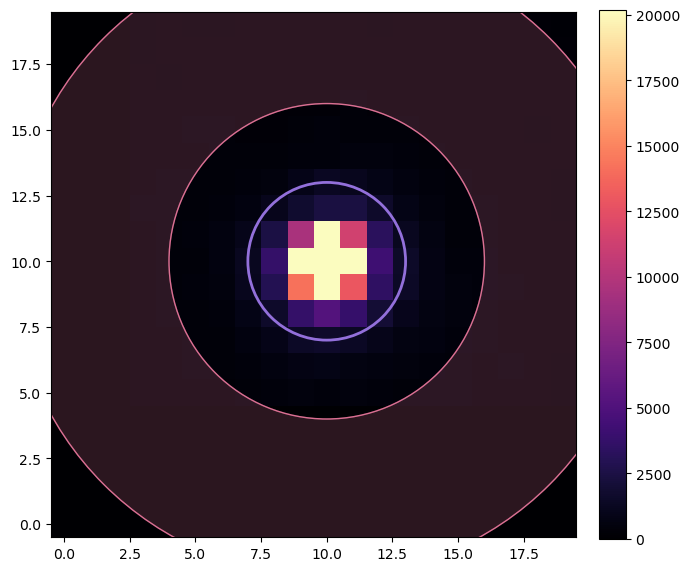

In [142]:
sci_files_toi = sorted(glob.glob(f"{my_path}/TOI-2046b_g_20251031_*_toi.fits"))
fname = sci_files_toi[0]
with fits.open(fname) as hdul:
    data = hdul[0].data.astype(float)
    hdr = hdul[0].header

# --- Find centroid ---
y_centroid, x_centroid = center_of_mass(data)
print(f"Star centroid (subpixel): x={x_centroid:.3f}, y={y_centroid:.3f}")

# --- Manual offsets ---
dx_manual = 1
dy_manual = 1.5

# --- Shift image to center ---
ny, nx = data.shape
y_shift = (ny/2 - 0.5) - y_centroid + dy_manual
x_shift = (nx/2 - 0.5) - x_centroid + dx_manual
data_centered = shift(data, shift=(y_shift, x_shift), order=3)

# --- Cutout around center ---
cutout_size = 101
half_size = cutout_size // 2
y_center = ny // 2
x_center = nx // 2
cutout = data_centered[y_center-half_size:y_center+half_size+1,
                       x_center-half_size:x_center+half_size+1]

cutout_center_x = cutout.shape[1] // 2
cutout_center_y = cutout.shape[0] // 2

# --- Radial profile ---
yy, xx = np.indices(cutout.shape)
r = np.sqrt((xx - cutout_center_x)**2 + (yy - cutout_center_y)**2)
r_int = r.astype(int)

radial_mean = np.bincount(r_int.ravel(), weights=cutout.ravel()) / np.bincount(r_int.ravel())

# --- Estimate PSF FWHM from second moments ---
def estimate_fwhm(cutout, r_max=8):
    mask_core = r <= r_max
    y = yy[mask_core]; x = xx[mask_core]; z = cutout[mask_core]
    z = np.clip(z - np.median(z), 0, None)
    z_sum = z.sum()
    if z_sum == 0:
        return 3.0  # fallback
    x0 = (x*z).sum()/z_sum
    y0 = (y*z).sum()/z_sum
    sigx = np.sqrt(((x - x0)**2 * z).sum()/z_sum)
    sigy = np.sqrt(((y - y0)**2 * z).sum()/z_sum)
    sigma = np.sqrt(sigx*sigy)
    fwhm = 2.3548 * sigma
    return float(fwhm)

fwhm = estimate_fwhm(cutout)
print(f"Estimated FWHM ≈ {fwhm:.2f} px")

# --- Robust background estimate ---
core_exclude = r < max(6, 1.5*fwhm)
background_level, _, sigma_B = sigma_clipped_stats(cutout[~core_exclude], sigma=3.0, maxiters=5)

# --- Ring statistics ---
ring_means = []
max_r = r_int.max()
for rad in range(0, max_r+1):
    ring = (r_int == rad) & (~core_exclude)
    vals = cutout[ring]
    if vals.size < 20:
        ring_means.append(np.nan)
        continue
    m, _, _ = sigma_clipped_stats(vals, sigma=3.0, maxiters=5)
    ring_means.append(m)
ring_means = np.array(ring_means)

# Smooth lightly
window = 3
ring_means_s = np.convolve(np.nan_to_num(ring_means, nan=background_level),
                           np.ones(window)/window, mode='same')

# Slope and criteria
dI = np.diff(ring_means_s, prepend=ring_means_s[0])
epsilon = 0.8 * sigma_B
t = 1.5
M = 3
N = 3

def first_consecutive(indices, L):
    count = 0
    for i, val in enumerate(indices):
        count = count+1 if val else 0
        if count >= L:
            return i - L + 1
    return None

flat_hit = first_consecutive(np.abs(dI) < epsilon, M)
bg_hit = first_consecutive(np.abs(ring_means_s - background_level) < t*sigma_B, N)

# --- Aperture radius ---
r_ap = int(np.round(1.2 * fwhm))

# --- Inner annulus radius ---
k = 2.0
r_floor = int(np.ceil(k * fwhm))
candidates = [x for x in [flat_hit, bg_hit, r_floor] if x is not None]
r_in = max(candidates) if candidates else r_floor

# --- Outer annulus radius ---
r_out = r_in + max(6, int(1.5 * fwhm))

# --- Annulus area ---
annulus_area = np.pi * (r_out**2 - r_in**2)

print(f"Aperture radius (r_ap): {r_ap} pixels")
print(f"Inner annulus radius (r_in): {r_in} pixels")
print(f"Outer annulus radius (r_out): {r_out} pixels")
print(f"Background annulus area: {annulus_area:.2f} pixels²")

# --- Plot cutout with aperture ---
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cutout, cmap="magma", origin="lower",
               vmin=np.percentile(cutout, 5),
               vmax=np.percentile(cutout, 99))
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.add_patch(Circle((cutout_center_x, cutout_center_y), r_ap, color='mediumpurple', fill=False, lw=2))
ax.add_patch(Wedge((cutout_center_x, cutout_center_y), r_out, 0, 360, width=r_out-r_in, color='palevioletred', alpha=0.2))
ax.add_patch(Circle((cutout_center_x, cutout_center_y), r_in, color='palevioletred', fill=False, lw=1))
ax.add_patch(Circle((cutout_center_x, cutout_center_y), r_out, color='palevioletred', fill=False, lw=1))

ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('5110_final_annulus.pdf')
plt.show()